In [1]:
import os
import pandas as pd
from scipy.misc import imread
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
%matplotlib inline

def get_df_faces(directory0, directory1, preprocessing = False):
    imgs0 = list()
    for filename in os.listdir(directory0):
        if filename.endswith(".jpg"):
            img = cv2.imread(directory0 + filename, 0)
            if preprocessing:
                autocontrast(img, white_perc=0., black_perc = 0.)
                #img = hog(img, orientations=6, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualise=False)
                img = hog(img, orientations=6, pixels_per_cell=(2, 2), cells_per_block=(2, 2), visualise=False)
            else:
                img = np.reshape(img, (img.shape[0]*img.shape[1])).tolist()
            imgs0.append(img) 
        else:
            continue
    imgs1 = list()
    for filename in os.listdir(directory1):
        if filename.endswith(".jpg"):
            img = cv2.imread(directory1 + filename, 0)
            if preprocessing:
                autocontrast(img, white_perc=0., black_perc = 0.)
                #img = hog(img, orientations=6, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualise=False)
                img = hog(img, orientations=6, pixels_per_cell=(2, 2), cells_per_block=(2, 2), visualise=False)
            else:
                img = np.reshape(img, (img.shape[0]*img.shape[1])).tolist()
            imgs1.append(img) 
        else:
            continue
    Y_closed = np.full((1, len(imgs0)), 0)
    Y_opened = np.full((1, len(imgs1)), 1)
    return np.array(imgs0 + imgs1, dtype=np.float32), np.hstack((Y_closed, Y_opened))

In [2]:
from operator import itemgetter
def autocontrast(image, white_perc=0.2, black_perc = 0.2):
    img = image
    sorted_img = sorted(np.ndenumerate(img), key=itemgetter(1))
    pixels_number = len(sorted_img)
    black_border = float(black_perc)*pixels_number
    white_border = float(white_perc)*pixels_number
    for e in enumerate(sorted_img):
        if (int(round(black_border)) <= e[0] and 
           (e[0] == 0 or e[0] == pixels_number - 1 or img[e[1][0]] != sorted_img[e[0] + 1][1])):
            black_threshold_number = e[0]
            break
        else:
            img[e[1][0]] = 0

    reversed_sorted_img = list(reversed(sorted_img))
    for e in enumerate(reversed_sorted_img):
        if (int(round(white_border)) <= e[0] and 
           (e[0] == 0 or e[0] == pixels_number - 1 or img[e[1][0]] != reversed_sorted_img[e[0] + 1][1])):
            white_threshold_number = pixels_number - e[0] - 1
            break
        else:
            img[e[1][0]] = 255

    black_threshold = sorted_img[black_threshold_number][1]
    white_threshold = sorted_img[white_threshold_number][1]

    for e in enumerate(sorted_img[black_threshold_number : white_threshold_number + 1]):
        img[e[1][0]] = (img[e[1][0]] - black_threshold)*255 / float(white_threshold - black_threshold)

    return img


In [3]:
X, Y = get_df_faces("dataset_B_FacialImages/ClosedFace/", "dataset_B_FacialImages/OpenFace/", True)

/home/user/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((1, 1192), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/user/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((1, 1231), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


# Dimension reduction with preprocessing (LLE)

In [4]:
from sklearn.manifold import LocallyLinearEmbedding as LLE
n_components = 2

Neighbors = range(2,9)
results_LLE = []
for n_neighbors in Neighbors:
    print(n_neighbors, "processing...")
    lle = LLE(n_neighbors, n_components).fit_transform(X)
    results_LLE.append(lle)

(2, 'processing...')
(3, 'processing...')
(4, 'processing...')
(5, 'processing...')
(6, 'processing...')
(7, 'processing...')
(8, 'processing...')


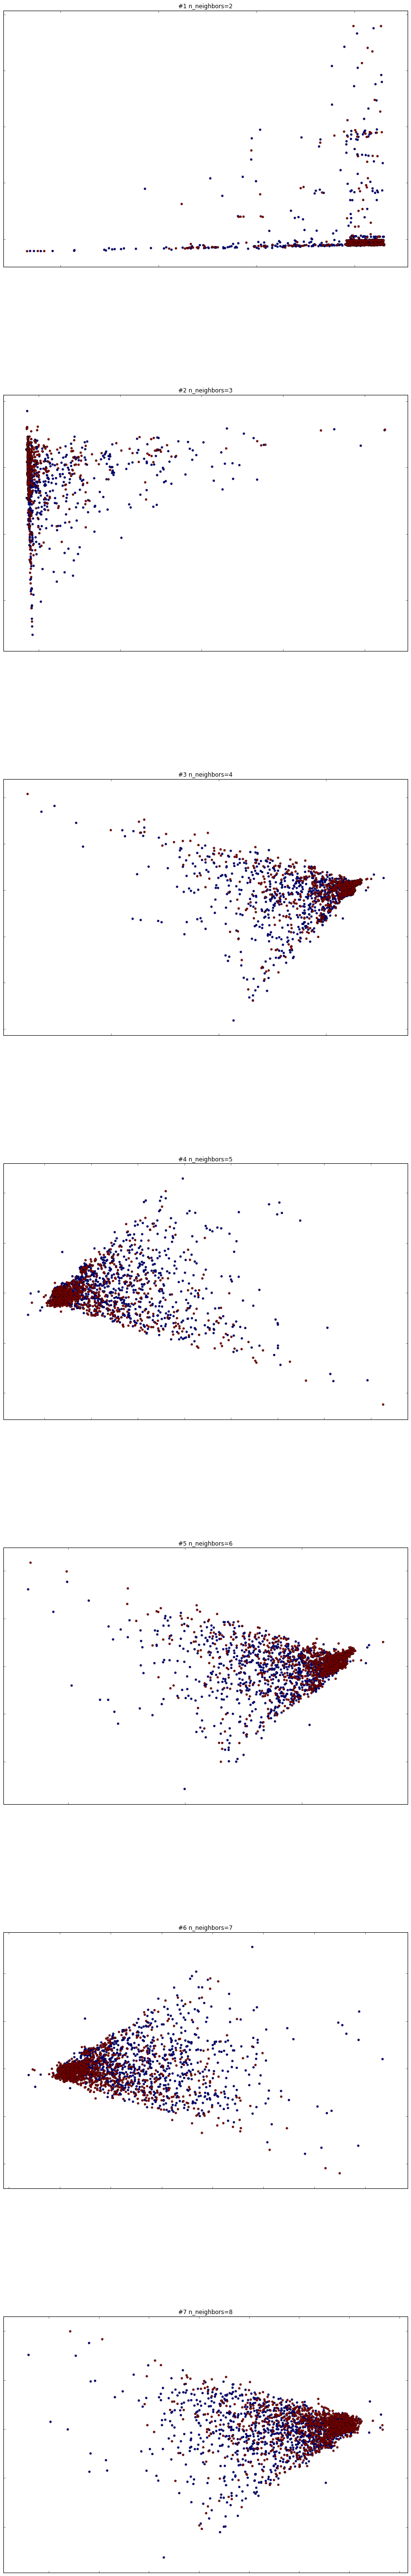

In [5]:
from matplotlib.ticker import NullFormatter
from matplotlib import colors as clrs
import matplotlib.pyplot as plt

color = clrs.Normalize()
color.autoscale(Y)
c = color(Y)
fig, axarr = plt.subplots(7, 1, figsize=(15, 95))

for i, lle in enumerate(results_LLE):
    ax = axarr[i]
    ax.scatter(lle[:, 0], lle[:, 1], c=c, lw = 0.3)# cmap=plt.cm.Spectral)
    ax.set_title("#{} n_neighbors={}".format(i + 1, Neighbors[i]))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


plt.setp([a.get_xticklabels() for a in axarr.flatten()], visible=False)
plt.setp([a.get_yticklabels() for a in axarr.flatten()], visible=False)

fig.subplots_adjust(hspace=.5)

plt.show()